In [0]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import io
import math 

In [211]:
uploaded = files.upload()

Saving GSPC_yahoo.txt to GSPC_yahoo.txt


In [0]:
sp500= pd.read_csv(io.BytesIO(uploaded['GSPC_yahoo.txt']))

In [217]:
sp500

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-05-10,1122.270020,1163.849976,1122.270020,1159.729980,1159.729980,6893700000
1,2010-05-11,1156.390015,1170.479980,1147.709961,1155.790039,1155.790039,5842550000
2,2010-05-12,1155.430054,1172.869995,1155.430054,1171.670044,1171.670044,5225460000
3,2010-05-13,1170.040039,1173.569946,1156.140015,1157.439941,1157.439941,4870640000
4,2010-05-14,1157.189941,1157.189941,1126.140015,1135.680054,1135.680054,6126400000
...,...,...,...,...,...,...,...
2513,2020-05-04,2815.010010,2844.239990,2797.850098,2842.739990,2842.739990,4723140000
2514,2020-05-05,2868.879883,2898.229980,2863.550049,2868.439941,2868.439941,5129590000
2515,2020-05-06,2883.139893,2891.110107,2847.649902,2848.419922,2848.419922,4861920000
2516,2020-05-07,2878.260010,2901.919922,2876.479980,2881.189941,2881.189941,5164640000


In [218]:
type(sp500)

pandas.core.frame.DataFrame

In [0]:
df = sp500.copy()

In [221]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-05-10,1122.270020,1163.849976,1122.270020,1159.729980,1159.729980,6893700000
1,2010-05-11,1156.390015,1170.479980,1147.709961,1155.790039,1155.790039,5842550000
2,2010-05-12,1155.430054,1172.869995,1155.430054,1171.670044,1171.670044,5225460000
3,2010-05-13,1170.040039,1173.569946,1156.140015,1157.439941,1157.439941,4870640000
4,2010-05-14,1157.189941,1157.189941,1126.140015,1135.680054,1135.680054,6126400000


In [222]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2513,2020-05-04,2815.010010,2844.239990,2797.850098,2842.739990,2842.739990,4723140000
2514,2020-05-05,2868.879883,2898.229980,2863.550049,2868.439941,2868.439941,5129590000
2515,2020-05-06,2883.139893,2891.110107,2847.649902,2848.419922,2848.419922,4861920000
2516,2020-05-07,2878.260010,2901.919922,2876.479980,2881.189941,2881.189941,5164640000
2517,2020-05-08,2908.830078,2932.159912,2902.879883,2929.800049,2929.800049,4857160000


In [223]:
df.shape

(2518, 7)

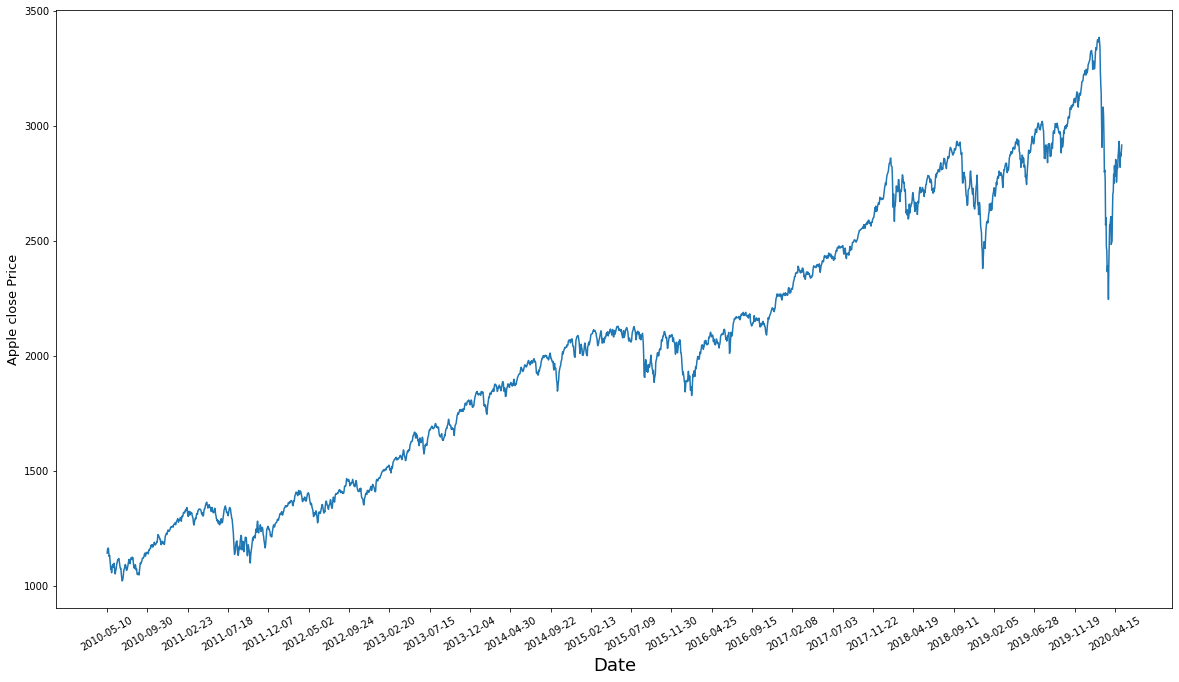

In [225]:
plt.figure(figsize = (20,11))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=30)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Apple close Price',fontsize=13)
plt.show()

In [0]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/1.0

In [227]:
mid_prices.shape

(2518,)

In [0]:
train_data = mid_prices[:2500]
test_data = mid_prices[2500:]

In [232]:
train_data.shape

(2000,)

In [233]:
test_data.shape

(518,)

# Feature Scaling

In [0]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [235]:
type(train_data)

numpy.ndarray

In [0]:
smoothing_window_size = 500
for di in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [254]:
train_data
print(train_data,train_data.shape)

[[0.        ]
 [0.00644333]
 [0.01548043]
 ...
 [0.47739239]
 [0.44348519]
 [0.51073802]] (2500, 1)


Reshaping data back 

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


In [239]:
print(train_data)

[0.30717897 0.34794879 0.36080155 ... 0.78195602 0.81358709 0.82284548]


EMA smoothing

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2500):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

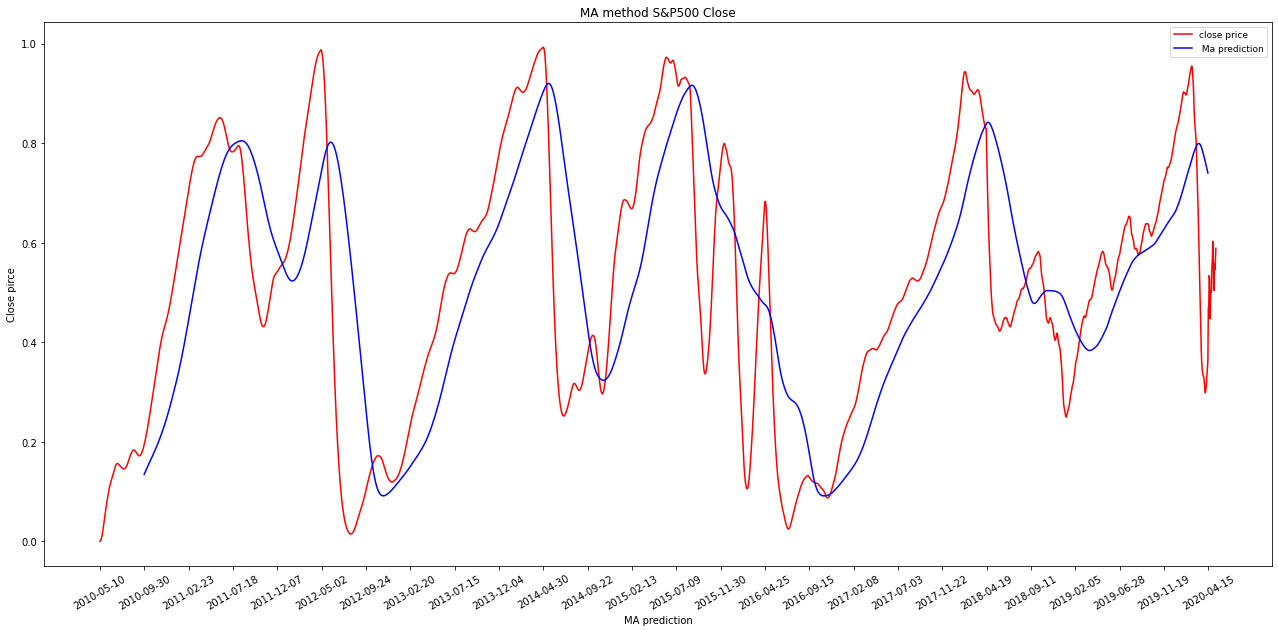

MSE error for standard averaging: 114.64507
RMSE error: 10.70724


In [257]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []
count = 0
for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx -500])**2)
    count +=1
    std_avg_x.append(date)



plt.figure(figsize = (22,10))
plt.plot(range(df.shape[0]),all_mid_data,color='r',label='close price')
plt.plot(range(window_size,N),std_avg_predictions,color='b',label=' Ma prediction')
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=30)
plt.xlabel('MA prediction')
plt.ylabel('Close pirce')
plt.legend(fontsize=9)
plt.title('MA method S&P500 Close')
plt.show()

print('MSE error for standard averaging: %.5f'%(1000.0 *np.mean(mse_errors)))
print('RMSE error: %.5f'% math.sqrt((1000.0* np.mean(mse_errors))))

In [0]:
train_data_returns = train_data.copy()

In [0]:
train_data

array([0.03143791, 0.06067836, 0.08698315, ..., 0.36416683, 0.36609824,
       0.36710277])

In [0]:
import pandas as pd

In [0]:
train_data_ret_series = pd.Series(train_data)


In [0]:
train_data_ret_series

1        93.010157
2        43.351194
3        27.588038
4        19.746699
5        14.841352
           ...    
10995     0.208782
10996     0.873435
10997     0.737321
10998     0.530362
10999     0.274389
Length: 10999, dtype: float64

In [0]:
train_data_ret_series = train_data_ret_series.pct_change(1).mul(100)

In [0]:
train_data_ret_series

1        93.010157
2        43.351194
3        27.588038
4        19.746699
5        14.841352
           ...    
10995     0.208782
10996     0.873435
10997     0.737321
10998     0.530362
10999     0.274389
Length: 10999, dtype: float64

In [0]:
train_data_ret_series = train_data_ret_series[1:]

In [0]:
train_data_ret = train_data_ret_series.to_numpy()

In [0]:
train_data_ret.shape

(10999,)

In [0]:
train_data_ret

array([93.01015697, 43.35119361, 27.58803812, ...,  0.73732126,
        0.53036184,  0.27438851])

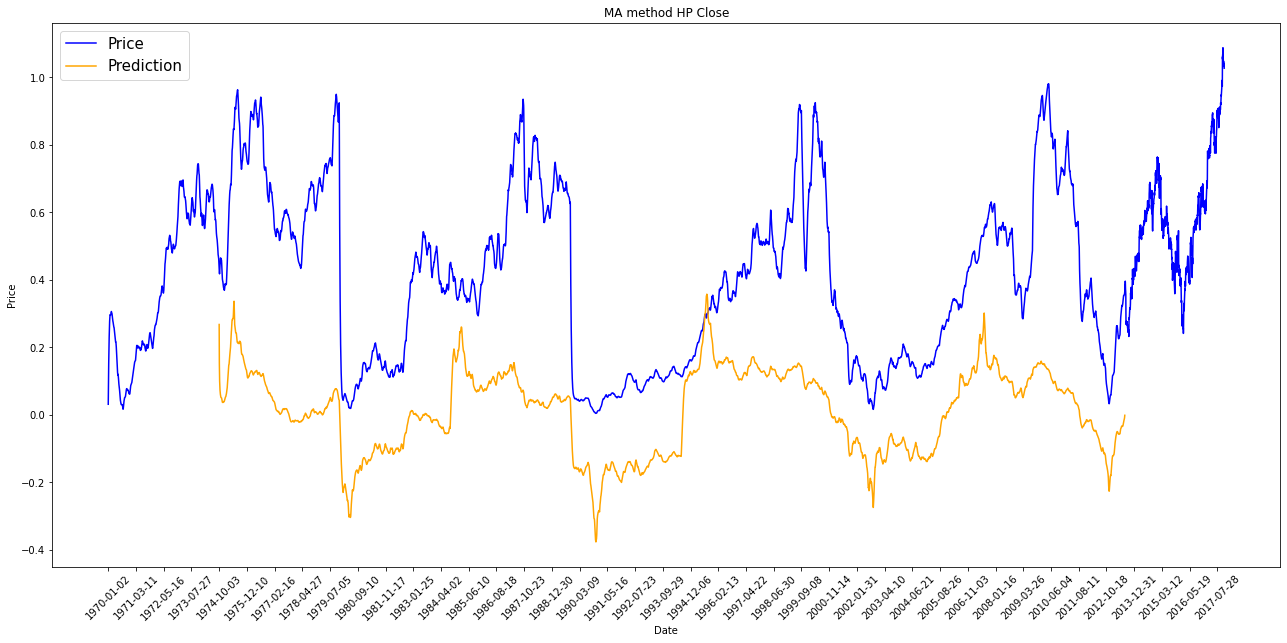

MSE error for standard averaging: 2183.16960
RMSE error: 46.72440


In [0]:
window_size = 1200
N = train_data_ret.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []
count = 0
for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data_ret[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data_ret[pred_idx -1])**2)
    count +=1
    std_avg_x.append(date)



plt.figure(figsize = (22,10))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='Price')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df.shape[0],300),df['Date'].loc[::300],rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fontsize=15)
plt.title('MA method HP Close')
plt.show()

print('MSE error for standard averaging: %.5f'%(1200.0 *np.mean(mse_errors)))
print('RMSE error: %.5f'% math.sqrt((1200.0* np.mean(mse_errors))))

In [0]:
print(std_avg_predictions[-1])
print(train_data[pred_idx])

0.4878919099269631
0.36710276745268855


In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
window_size = 500
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx-100])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.01172


TypeError: ignored

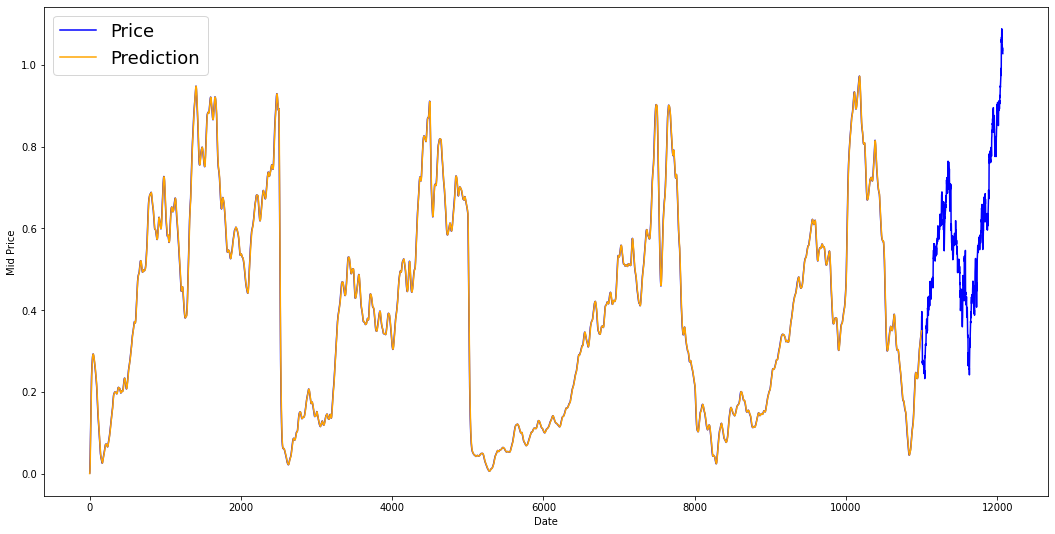

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='Price')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

One solution you have that will output useful information is to look at momentum-based algorithms. They make predictions based on whether the past recent values were going up or going down (not the exact values). For example, they will say the next day price is likely to be lower, if the prices have been dropping for the past days, which sounds reasonable. However, you will use a more complex model: an LSTM model.

These models have taken the realm of time series prediction by storm, because they are so good at modelling time series data. You will see if there actually are patterns hidden in the data that you can exploit.

In [0]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.03143791 0.6904868  0.82829314 0.32585657 0.11600105]

	Output: [0.132895   0.6858036  0.8329321  0.33078218 0.11600105]


Unrolled index 1
	Inputs:  [0.06067836 0.6890754  0.8325337  0.32857886 0.11785509]

	Output: [0.15261841 0.6836884  0.833369   0.33078218 0.11785509]


Unrolled index 2
	Inputs:  [0.08698314 0.68685144 0.8329321  0.33078218 0.11946969]

	Output: [0.17132245 0.6848606  0.8329321  0.33355275 0.12192084]


Unrolled index 3
	Inputs:  [0.11098009 0.6858036  0.83294916 0.33219692 0.12106793]

	Output: [0.15261841 0.6826334  0.83420646 0.33650374 0.12288672]


Unrolled index 4
	Inputs:  [0.132895   0.6848606  0.833369   0.33355275 0.12158521]

	Output: [0.17132245 0.6836884  0.833141   0.3404623  0.12158521]


### Defining Hyperparameters

In [0]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount
tf.reset_default_graph() # This is important in case you run this multiple times

### Defining Inputs and Outputs

In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

### Defining Parameters of the LSTM and Regression layer

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


# Calculating LSTM output and Feeding it to the regression layer to get final prediction

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Loss Calculation and Optimizer

In [0]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
	All done


## Prediction Related Calculations

In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [0]:
train_data

array([0.03143791, 0.06067836, 0.08698315, ..., 0.36416683, 0.36609824,
       0.36710277])

## Running the LSTM

In [0]:
epochs = 10
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 2.023325


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


	Test MSE: 0.00716
	Finished Predictions
Average loss at step 2: 0.129522
	Test MSE: 0.00286
	Finished Predictions
Average loss at step 3: 0.083088
	Test MSE: 0.00413
	Finished Predictions
Average loss at step 4: 0.068571
	Test MSE: 0.00350
	Finished Predictions
Average loss at step 5: 0.059363
	Decreasing learning rate by 0.5
	Test MSE: 0.00288
	Finished Predictions
Average loss at step 6: 0.056130
	Test MSE: 0.00273
	Finished Predictions
Average loss at step 7: 0.054582
	Test MSE: 0.00271
	Finished Predictions
Average loss at step 8: 0.052802
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 9: 0.052764
	Test MSE: 0.00244
	Finished Predictions
Average loss at step 10: 0.050418
	Test MSE: 0.00231
	Finished Predictions


In [0]:
np.amin(predictions_over_time)
result = np.where(predictions_over_time == np.amin(predictions_over_time))
print(result)

(array([1]), array([1]), array([49]))


## Visualizing the results


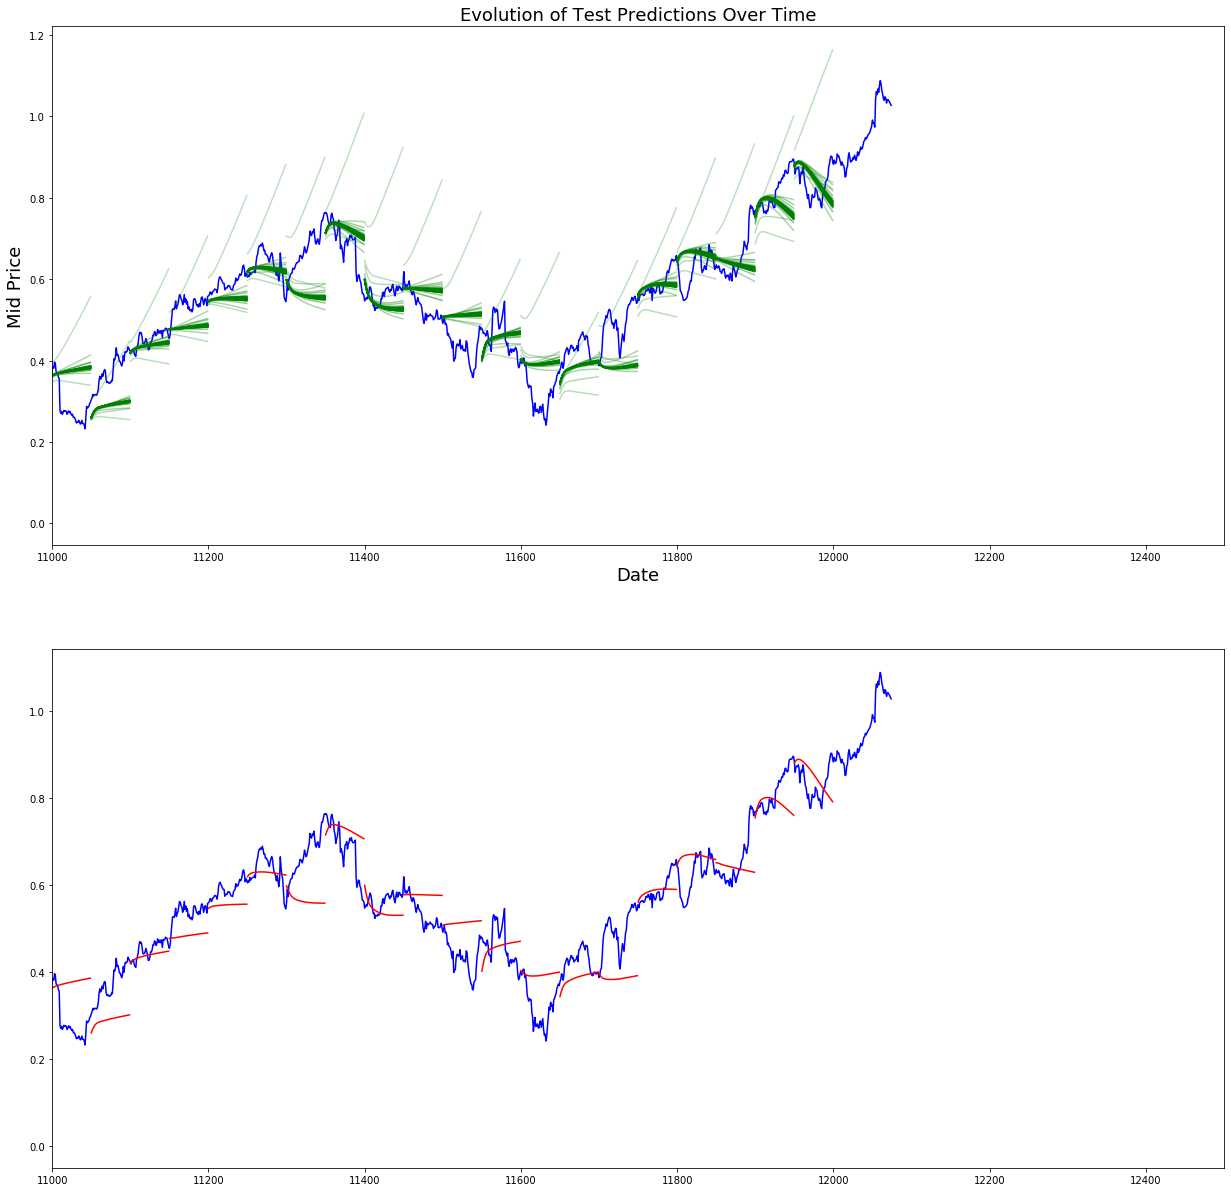

In [0]:
best_prediction_epoch = 49 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (21,21))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='g',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    plt.xlim(11000,12500)